<h2> Import das bibliotecas</h2>

In [1]:
import cv2
import os

from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

DATAPATH = "data/leaf.csv"
SEED = 92

XLABELS = [str(x) for x in range(1,15+1)] +[str(x) for x in range(22, 36+1)]
FEATURELABELS = ["Excentricidade", "Proporção", "Alongamento", "Solidez", 
                 "Convexidade estocática", "Fator isoperimétrico", "Profundidade de indentação max.", "Lobedness", 
                "Intensidade média", "Contraste médio", "Suavidade", "Terceiro momento", "Uniformidade", "Entropia"]

#Todos os algoritmos para calcular o CROSS VALIDATION são baseados no código encontrado em:
# https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

<h2>Leitura</h2>

In [2]:
leafdata = np.genfromtxt(DATAPATH, delimiter = ",")

X = leafdata[:, 2:]
Y = leafdata[:, 0]

X, Y = shuffle(X, Y)

<h3>Feature Importance</h3>

In [3]:
# Single tree
single_tree = RandomForestClassifier(n_estimators=1, max_features=None, criterion="gini", bootstrap = False, random_state = SEED, class_weight="balanced", n_jobs=-1)
single_tree.fit(X, Y)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1, n_jobs=-1, oob_score=False, random_state=92,
            verbose=0, warm_start=False)

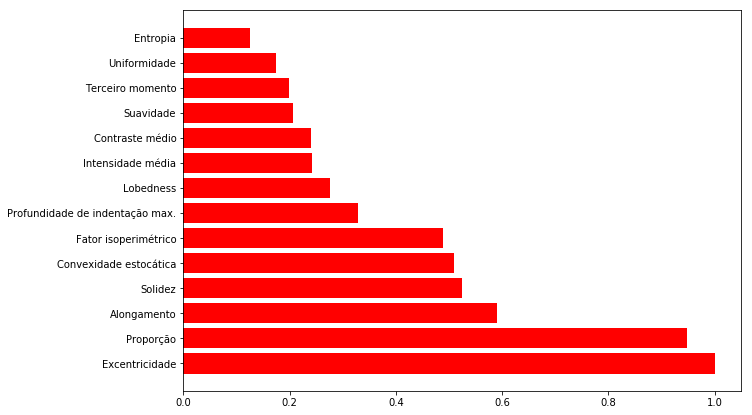

In [4]:
# código encontrado em https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = single_tree.feature_importances_
std = np.std([tree.feature_importances_ for tree in single_tree.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

max_importance = max(importances)

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. %s (%f)" % (f + 1, FEATURELABELS[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (10,7))
plt.barh(range(X.shape[1]), (importances[indices]/max_importance),
       color="r", align="center")
plt.yticks(range(X.shape[1]), FEATURELABELS)
plt.show()

<h3>Bootstrap</h3>

In [5]:
#Calcula erro OOB
sb_forest = RandomForestClassifier(max_features=None, criterion="entropy", bootstrap = False, random_state = SEED, class_weight="balanced", n_jobs=-1)
b_forest = RandomForestClassifier(max_features=None, criterion="entropy", bootstrap = True, random_state = SEED, class_weight="balanced", n_jobs=-1)


min_estimators = 1
max_estimators = 25 # temos problemas apos 125

estimators = []

for i in tqdm(range(min_estimators, max_estimators+1)):
    sb_forest.set_params(n_estimators = i)
    b_forest.set_params(n_estimators = i)
    
    results = []
    models = [sb_forest, b_forest]
    
    for model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=SEED)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")
        results.append(cv_results)
    
    estimators.append([i, "Não", results[0].mean()])
    estimators.append([i, "Sim", results[1].mean()])

100%|██████████| 25/25 [02:39<00:00,  8.30s/it]


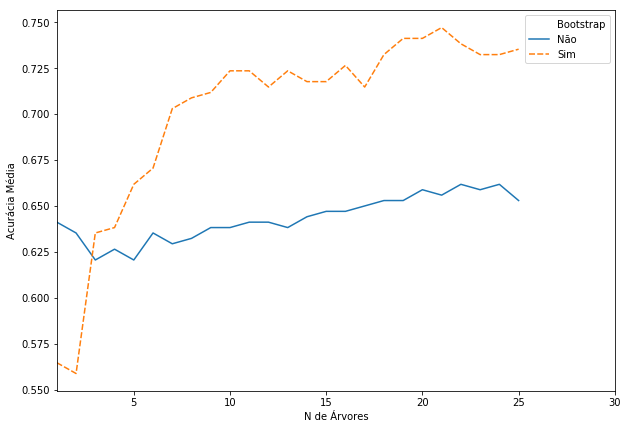

In [6]:
#Gera gŕafico do erro OOB
p = pd.DataFrame(np.array(estimators), columns=["N de Árvores", "Bootstrap", "Valor"])
p["N de Árvores"] = p["N de Árvores"].astype(np.int8)
p["Bootstrap"] = p["Bootstrap"].astype("category")
p["Acurácia Média"] = p["Valor"].astype(np.float32)
                                                
    
plt.figure(figsize=(10, 7))
plt.xlim((min_estimators, max_estimators+5))
g = sn.lineplot(x="N de Árvores", y="Acurácia Média", hue="Bootstrap", style="Bootstrap", data=p)

In [7]:
models = [("bootstrap", b_forest), ("sem bootstrap", sb_forest)]

results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=SEED)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

bootstrap: 0.735294 (0.064438)
sem bootstrap: 0.652941 (0.064169)


<h2>Função de Ganho</h2>

In [8]:
#Calcula erro OOB
gini_forest = RandomForestClassifier(n_estimators=100, max_features=None, criterion="gini", bootstrap = True, oob_score = True, random_state = SEED, class_weight="balanced", n_jobs=-1)
entropy_forest = RandomForestClassifier(n_estimators=100, max_features=None, criterion="entropy", bootstrap = True, oob_score = True, random_state = SEED, class_weight="balanced", n_jobs=-1)

min_estimators = 20
max_estimators = 150 # temos problemas apos 125

estimators = []

for i in tqdm(range(min_estimators, max_estimators+1)):
    gini_forest.set_params(n_estimators = i)
    gini_forest.fit(X, Y)  # X e Y utilizados!!
   
    entropy_forest.set_params(n_estimators = i)
    entropy_forest.fit(X, Y)  # X e Y utilizados!!!

    gini_oob_error = 1 - gini_forest.oob_score_
    entropy_oob_error = 1 - entropy_forest.oob_score_
    
    estimators.append([i, "gini", gini_oob_error])
    estimators.append([i, "entropia", entropy_oob_error])

100%|██████████| 131/131 [02:24<00:00,  1.81s/it]


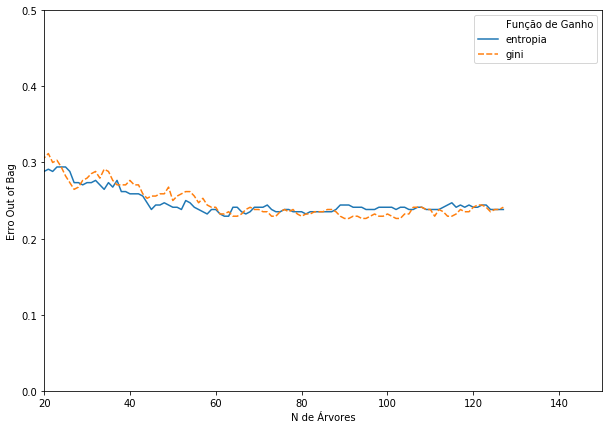

In [9]:
#Gera gráfico do erro OOB
p = pd.DataFrame(np.array(estimators), columns=["Estimators", "Method", "Value"])
p["N de Árvores"] = p["Estimators"].astype(np.int8)
p["Função de Ganho"] = p["Method"].astype("category")
p["Erro Out of Bag"] = p["Value"].astype(np.float32)
                                                
    
plt.figure(figsize=(10, 7))
plt.xlim((min_estimators, max_estimators))
plt.ylim((0, 0.5))
g = sn.lineplot(x="N de Árvores", y="Erro Out of Bag", hue="Função de Ganho", style="Função de Ganho", data=p)

In [10]:
criter = "gini"
#featuresImportance(gini_forest)
#featuresImportance(entropy_forest) # esse possui maior sd

In [11]:
#Cross validation das variações na função de ganho
for i in [25, 50, 75, 100, 125]:
    gini_forest.set_params(n_estimators=i)
    entropy_forest.set_params(n_estimators=i)
    models = []

    models.append(("Gini", gini_forest))
    models.append(("Entropy", entropy_forest))

    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=SEED)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s %d arvores: %.3f (%.3f)" % (name, i, cv_results.mean(), cv_results.std())
        print(msg)

Gini 25 arvores: 0.762 (0.065)
Entropy 25 arvores: 0.735 (0.064)
Gini 50 arvores: 0.756 (0.054)
Entropy 50 arvores: 0.741 (0.066)
Gini 75 arvores: 0.768 (0.053)
Entropy 75 arvores: 0.744 (0.067)
Gini 100 arvores: 0.768 (0.058)
Entropy 100 arvores: 0.744 (0.067)
Gini 125 arvores: 0.776 (0.055)
Entropy 125 arvores: 0.738 (0.061)


<h3>Quantidade de features de cada árvore</h3>

In [12]:
#Calcula erro OOB
p_forest = RandomForestClassifier(max_features=14, criterion="gini", bootstrap = True, oob_score = True, random_state = SEED, class_weight="balanced", n_jobs=-1)
p2_forest = RandomForestClassifier(max_features=7, criterion="gini", bootstrap = True, oob_score = True, random_state = SEED, class_weight="balanced", n_jobs=-1)
sqrt_forest = RandomForestClassifier(max_features="sqrt", criterion="gini", bootstrap = True, oob_score = True, random_state = SEED, class_weight="balanced", n_jobs=-1)


min_estimators = 20
max_estimators = 150 # temos problemas apos 125

estimators = []

for i in tqdm(range(min_estimators, max_estimators+1)):
    p_forest.set_params(n_estimators = i)
    p_forest.fit(X, Y)  # X e Y utilizados!!
   
    p2_forest.set_params(n_estimators = i)
    p2_forest.fit(X, Y)  # X e Y utilizados!!!

    sqrt_forest.set_params(n_estimators = i)
    sqrt_forest.fit(X, Y)  # X e Y utilizados!!!
    
    p_oob_error = 1 - p_forest.oob_score_
    p2_oob_error = 1 - p2_forest.oob_score_
    sqrt_oob_error = 1 - sqrt_forest.oob_score_
    
    estimators.append([i, "p", p_oob_error])
    estimators.append([i, "p/2", p2_oob_error])
    estimators.append([i, "sqrt", sqrt_oob_error])

100%|██████████| 131/131 [01:51<00:00,  1.06s/it]


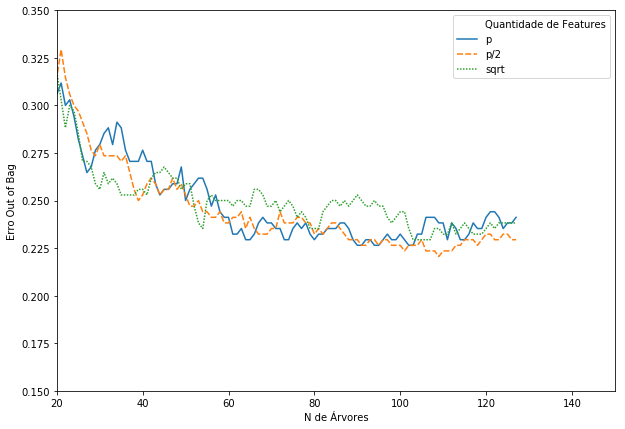

In [13]:
#Gera gŕafico do erro OOB
p = pd.DataFrame(np.array(estimators), columns=["Estimators", "Predictors", "Value"])
p["N de Árvores"] = p["Estimators"].astype(np.int8)
p["Quantidade de Features"] = p["Predictors"].astype("category")
p["Erro Out of Bag"] = p["Value"].astype(np.float32)
                                                
    
plt.figure(figsize=(10, 7))
plt.xlim((min_estimators, max_estimators))
plt.ylim((0.15, 0.35))
g = sn.lineplot(x="N de Árvores", y="Erro Out of Bag", hue="Quantidade de Features", style="Quantidade de Features", data=p)

In [14]:
#Cross validation para cada número max de features
for i in [25, 50, 75, 100, 125]:
    p_forest.set_params(n_estimators=i)
    p2_forest.set_params(n_estimators=i)
    sqrt_forest.set_params(n_estimators=i)
    models = []

    models.append(("P", p_forest))
    models.append(("P/2", p2_forest))
    models.append(("SQRT", sqrt_forest))
    
    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=SEED)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s %d arvores: %.3f (%.3f)" % (name, i, cv_results.mean(), cv_results.std())
        print(msg)

P 25 arvores: 0.762 (0.065)
P/2 25 arvores: 0.744 (0.078)
SQRT 25 arvores: 0.726 (0.059)
P 50 arvores: 0.756 (0.054)
P/2 50 arvores: 0.774 (0.077)
SQRT 50 arvores: 0.750 (0.053)
P 75 arvores: 0.768 (0.053)
P/2 75 arvores: 0.774 (0.070)
SQRT 75 arvores: 0.750 (0.059)
P 100 arvores: 0.768 (0.058)
P/2 100 arvores: 0.774 (0.062)
SQRT 100 arvores: 0.762 (0.065)
P 125 arvores: 0.776 (0.055)
P/2 125 arvores: 0.776 (0.071)
SQRT 125 arvores: 0.759 (0.061)


<h3>Quantidade de Árvores por Floresta</h3>

In [15]:
#Cross validation para cada quantidade de árvores por floresta
best_forest = RandomForestClassifier(max_features=7, criterion="gini", bootstrap = True, oob_score = True, random_state = SEED, class_weight="balanced", n_jobs=-1)

for i in [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350]:
    best_forest.set_params(n_estimators=i)
    models = []

    models.append(("Best", best_forest))
    
    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=SEED)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s alpha=%d: %.3f (%.3f)" % (name, i, cv_results.mean(), cv_results.std())
        print(msg)

Best alpha=100: 0.774 (0.062)
Best alpha=125: 0.776 (0.071)
Best alpha=150: 0.771 (0.055)
Best alpha=175: 0.776 (0.066)
Best alpha=200: 0.779 (0.059)
Best alpha=225: 0.776 (0.066)
Best alpha=250: 0.774 (0.065)
Best alpha=275: 0.779 (0.066)
Best alpha=300: 0.785 (0.067)
Best alpha=325: 0.782 (0.066)
Best alpha=350: 0.779 (0.069)
